In [14]:
import json
import pandas as pd
import cv2
import numpy as np
from enum import Enum, auto

In [15]:
with open('json_structure') as json_file:
    data = json.load(json_file)

In [16]:
root_dir = "/work3/s174159/data/"
video_file = root_dir + "00/01/c920-1.avi"
bb_file = root_dir + "bbox/00/01/c920-1.face"

In [17]:
# reading csv files
data =  pd.read_csv(bb_file, sep=" ", header=None, names=["frame", "x", "y", "w", "h"]).drop("frame", axis=1)

In [18]:

class Method(Enum):
	'''Available methods for processing an image
			REGION_BASED: segment the skin using the HSV and YCbCr colorspaces, followed by the Watershed algorithm'''
	REGION_BASED = auto()


class SkinDetector():

	def __init__(self, frame) -> None:
		self.image = frame
		self.image_mask = None
		self.skin = None

	def find_skin(self, method=Method.REGION_BASED) -> None:
		'''function to process the image based on some method '''
		if (method == Method.REGION_BASED):
			self.__color_segmentation()
			self.__region_based_segmentation()

	def get_resulting_images(self) -> tuple:
		"""Returns the processed images
				[0] = The original image
				[1] = The resulting image mask containing the skin
				[2] = The result image after a bitwise_and of [1] and [0]"""

		return self.image, self.image_mask, self.skin

	def __color_segmentation(self) -> None:
		'''Apply a threshold to an HSV and YCbCr images, the used values were based on current research papers along with some empirical tests and visual evaluation'''

		HSV_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
		YCbCr_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCR_CB)

		lower_HSV_values = np.array([0, 40, 0], dtype="uint8")
		upper_HSV_values = np.array([25, 255, 255], dtype="uint8")

		lower_YCbCr_values = np.array((0, 138, 67), dtype="uint8")
		upper_YCbCr_values = np.array((255, 173, 133), dtype="uint8")

		# A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
		mask_YCbCr = cv2.inRange(YCbCr_image, lower_YCbCr_values, upper_YCbCr_values)
		mask_HSV = cv2.inRange(HSV_image, lower_HSV_values, upper_HSV_values)

		self.skin_mask = cv2.add(mask_HSV, mask_YCbCr)

	def __region_based_segmentation(self) -> None:
		'''Function that applies Watershed and morphological operations on the thresholded image morphological operations'''

		image_foreground = cv2.erode(self.skin_mask, None, iterations=3)  # remove noise

		# The background region is reduced a little because of the dilate operation
		dilated_binary_image = cv2.dilate(self.skin_mask, None, iterations=3)
		# set all background regions to 128
		_, image_background = cv2.threshold(dilated_binary_image, 1, 128, cv2.THRESH_BINARY)

		# add both foreground and background, forming markers. The markers are "seeds" of the future image regions.
		image_marker = cv2.add(image_foreground, image_background)
		image_marker32 = np.int32(image_marker)  # convert to 32SC1 format

		image_marker32 = cv2.watershed(self.image, image_marker32)
		m = cv2.convertScaleAbs(image_marker32)  # convert back to uint8

		# bitwise of the mask with the input image
		_, self.image_mask = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
		self.skin = cv2.bitwise_and(self.image, self.image, mask=self.image_mask)

	def show_all_images(self, window_title="Original Image | Skin Mask | Result") -> None:
		'''Show all processed images concatenated along the 1 axis using imshow '''
		rgb_mask = cv2.cvtColor(self.image_mask, cv2.COLOR_GRAY2RGB)
		cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)
		cv2.imshow(window_title, np.concatenate((self.image, rgb_mask, self.skin), axis=1))
		cv2.waitKey(0)

In [20]:

from IPython.display import display, Image

video = cv2.VideoCapture(video_file)
display_handle=display(None, display_id=True)
i = 0
try:
    while True:
        _, frame = video.read()
        if i == len(data):
            i = 0
        x, y, w, h = data.iloc[i].values.astype(int)
        i+= 1
        frame = frame[y:y+h,x:x+w]
        detector = SkinDetector(frame)
        detector.find_skin()
        image, mask, skin = detector.get_resulting_images()
        #frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', skin)
        display_handle.update(Image(data=frame.tobytes()))
        #display_handle.update(Image(data=skin.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

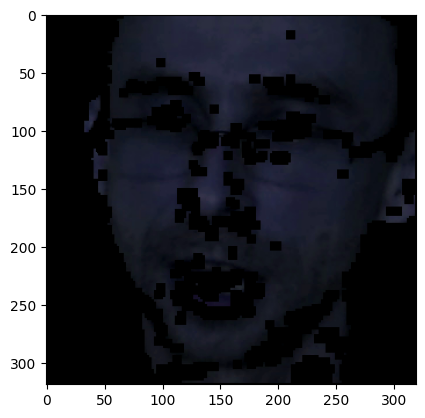

In [21]:
import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(skin)
plt.show()